# Ensemble Learning and Random Forests

In ensemble learning the model does not consist of just one but many predictors that vote on the final prediction, which often leads to better predictions through capturing somehing similar to "wisdom of the crowd" in humans. 

Example: If you split the training set in 100 subsets and train classification decision trees separately on them, then combine them to a ensemble model where the final prediction depends on the majority vote, you have generated a **Random Forest classifier**.

**Tips:**
- Ensemble methods are best used towards the end of the model building phase when you already established a few good predictors to combine.
- Make sure the individual predictors are as independent from another as possible to not capture the same mistake or type of error. This can be done by choosing predictors with very different algorithms

Important concepts:
- Bagging: training on random subsets (sampling) with replacement; short for bootstrap aggregation
- Pasting: sampling without replacement
- Boosting
- Stacking

## 1. Classification ensemble model example

Consisting of Random Forest, Logistic Regression, and Support Vector Classifier

Individual Performance (Validation Score):
- Random Forest: 0.992
- Logistic Regression: 0.87
- Support Vector Machine Classifier: 0.9955
- Hard Voting: 0.9935

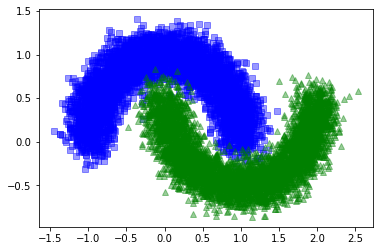

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.14, random_state=32)

plt.plot(X[y==0, 0], X[y==0,1], "bs", alpha=0.4)
plt.plot(X[y==1, 0], X[y==1,1], "g^", alpha=0.4)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)
rnd_clf.score(X_test, y_test) # test score

0.992

In [16]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test) # test score

0.87

In [17]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test) # test score

0.9955

In [24]:
# Hard Voting

from sklearn.ensemble import VotingClassifier

hard_voting_clf = VotingClassifier(
    estimators=[('rnd_clf', rnd_clf), ('log_reg', log_reg), ('svm_clf', svm_clf)],
    voting='hard'
    )

hard_voting_clf.fit(X_train, y_train)
hard_voting_clf.score(X_test, y_test) # test score

0.9935

In [25]:
# Alternative: Loop through individual models

from sklearn.metrics import accuracy_score

for clf in (rnd_clf, log_reg, svm_clf, hard_voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.9925
LogisticRegression 0.87
SVC 0.9955
VotingClassifier 0.994


If all predictors are able to predict class probability, i.e. they have the predict_proba() method, then we can use **soft voting where the class probability is the average of all predicted probabilities**. Thus, very confident models would have higher weights in the overall prediction which often leads to better results than hard voting.

Note: We need to set the probability hyperparameter to True for SVC to work in soft voting

In [28]:
# Soft Voting
from sklearn.ensemble import VotingClassifier

soft_voting_clf = VotingClassifier(
    estimators=[('rnd_clf', rnd_clf), ('log_reg', log_reg), ('svm_clf', SVC(probability=True))],
    voting='soft'
    )

soft_voting_clf.fit(X_train, y_train)
soft_voting_clf.score(X_test, y_test) # test score

0.9925

## 2. Bagging and Pasting

Instead of using very different training algorithms we can use the same algorithm on random subsets of the training set. 

When sampling is performed with replacement, this is called **bagging**, which stands for bootstrap aggregation.

Sampling without replacement is called **pasting**.

The predictions of the individual predictors are typically **aggregated using a statistical method** like in hard voting the most frequent predicted class or the average for regression.

The individual predictors have higher bias than when trained on the entire training set, but aggregation reduces both bias and variance. Usually, the ensemble has a similar bias but lower variance than a single predictor trained on the training set.

In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Bagging: 
# 500 decision trees with each 1000 samples with replacement
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=1000, bootstrap=True, n_jobs=-1
    )

bag_clf.fit(X_train, y_train)
bag_clf.score(X_test, y_test)

0.992

In [35]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Pasting: 
# 500 decision trees with each 1000 samples without replacement
past_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=1000, bootstrap=False, n_jobs=-1
    )

past_clf.fit(X_train, y_train)
past_clf.score(X_test, y_test)

0.9905

A bagging ensemble can be evaluated without a separate validation set using **Out-of-Bag (OOB)** instances. OOB instances are data of the training set that are not used by the bagging predictor

In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Bagging: 
# with OOB evaluation
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1,
    oob_score=True
    )

bag_clf.fit(X_train, y_train)
print("OOB score: " + str(bag_clf.oob_score_))

# versus test set
y_pred = bag_clf.predict(X_test)
print("Validation score (Test Set): " + str(accuracy_score(y_test, y_pred)))

OOB score: 0.99075
Validation score (Test Set): 0.9895


So far we only talked about sampling of instances. We can also do **feature sampling** in a similar way using BaggingClassifier and the hyperparameters bootstrap_features and max_features. This is particularily useful when dealing with a high-dimensional inputs.


**Random Subspaces** method is used when we do feature sampling without instance sampling (bootstrap_features = True, max_samples=1.0)

**Random Patches** method uses both feature sampling and instance sampling.

In [38]:
# Random Subspace: 
# doesnt make sense here with only two features
rndsub_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=1, bootstrap=False,
    max_features=0.6, bootstrap_features=True,
    n_jobs=-1
    )

rndsub_clf.fit(X_train, y_train)
rndsub_clf.score(X_test, y_test)

0.51

In [39]:
# Random Patches: 
# doesnt make sense here with only two features
rndpat_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=0.6, bootstrap=True, 
    max_features=0.6, bootstrap_features=True,
    n_jobs=-1
    )

rndpat_clf.fit(X_train, y_train)
rndpat_clf.score(X_test, y_test)

0.898

## 3. Random Forest and Extra-Trees

A **Random Forest** is an ensemble model consisting of decision trees and usually trained via the bagging method. 

Furthermore, random forest introduces extra randomness through searching for the best feature among a random subest of features when splitting a node. This trades higher bias for lower variance, resulting in an in general overall better model.

**Extremely Randomized Trees** or Extra-Trees are usually trained on the whole data set without bagging, but introduce extra randomness by not splitting at the optimum for a feature but randomly.

## 4. Boosting

Boosting is an ensemble method that **combines several weak learners (predictors that do not do a good job in their own) into a strong learner**. This is usally done by training the weak learners sequentially to correct the error of the predecessor.

The most well known boosting techniques are **AdaBoost** and **Gradient Boosting**.

### 4.1 AdaBoost
We start by training a base classifier such as a Decision Tree and use it to make predictions on the training set. Then we increase the weights of the misclassified instances and run a second classifier using the updated weights, make again predictions and increase the weights for the misclassified instances, and so on. This is repeated until the number of predictors is reached or the model has zero training error.

Very often AdaBoost is built using Decision trees of depth 1, also called decision stumps. When the classification error is calculated, we use weighted averages, so error of some instances are more important than others for the overall evaluation of the model.

Because AdaBoost models give more weight to some of the harder cases, we need to check for outliers beforehand, otherwise the generalizability of the model can be reduced. Furthermore, the sequential nature of the training process doesn't allow for parallelized training.

While AdaBoost is originally meant for binary classification problems, Scikit-Learn uses a multiclass version called SAMME. When class probabilities should be estimated, we can use a variant called SAMME.R. This also works for regression problems (AdaBoostRegressor).

In [44]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), # decision stumps
    n_estimators = 1000,
    algorithm="SAMME.R",
    learning_rate=0.5
)

ada_clf.fit(X_train, y_train)
print("Training score: " + str(ada_clf.score(X_train, y_train)))
print("Validation score: " + str(ada_clf.score(X_test, y_test)))

Training score: 0.997875
Validation score: 0.9905


### 4.2 Gradient Boosting
Like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble to correct its predecessor. However, Gradient Boosting tries to fit the new predictor to the residual errors instead of tweaking all instance weights at every iteration.

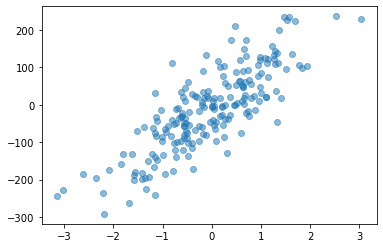

In [104]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

X, y = make_regression(n_samples=200, n_features=2, shuffle=True, random_state=12)
plt.scatter(X[:,0], y, alpha=0.5)

In [109]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X) # residual error round 1

print("Target for first instances: \n" + str(y[:5]))
print("Predictions for first instances: \n" + str(tree_reg1.predict(X)[:5]))
print("Residual error after round 1 for first instances: \n" + str(y2[:5]))

Target for first instances: 
[-69.83330294 -72.58745766  -7.15373396 -11.34477511 -98.56192178]
Predictions for first instances: 
[-175.34423049  -57.47277143   10.11181435  -57.47277143  -57.47277143]
Residual error after round 1 for first instances: 
[105.51092754 -15.11468623 -17.26554831  46.12799632 -41.08915035]


In [110]:
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

y3 = y - tree_reg2.predict(X) # residual error round 2

print("Target for first instances: \n" + str(y[:5]))
print("Predictions for first instances: \n" + str(tree_reg2.predict(X)[:5]))
print("Residual error after round 2 for first instances: \n" + str(y3[:5]))

Target for first instances: 
[-69.83330294 -72.58745766  -7.15373396 -11.34477511 -98.56192178]
Predictions for first instances: 
[11.57909592 11.57909592 11.57909592 11.57909592 11.57909592]
Residual error after round 2 for first instances: 
[ -81.41239886  -84.16655358  -18.73282988  -22.92387103 -110.1410177 ]


In [112]:
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

y4 = y - tree_reg3.predict(X) # residual error round 3

print("Target for first instances: \n" + str(y[:5]))
print("Predictions for first instances: \n" + str(tree_reg3.predict(X)[:5]))
print("Residual error after round 3 for first instances: \n" + str(y4[:5]))

Target for first instances: 
[-69.83330294 -72.58745766  -7.15373396 -11.34477511 -98.56192178]
Predictions for first instances: 
[-159.19512912  -54.12129958   15.5997354   -54.12129958  -54.12129958]
Residual error after round 3 for first instances: 
[ 89.36182618 -18.46615808 -22.75346936  42.77652447 -44.4406222 ]


In [117]:
# adding up the predictions of all trees
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))
print("Target for first instances: \n" + str(y[:5]))
print("Predictions for first instances after Gradient Boosting: \n" + str(y_pred[:5]))

# Model accuracy
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y,y_pred))
r2 = r2_score(y,y_pred)
print("RMSE: " + str(rmse))
print("R2 score: " + str(r2))

Target for first instances: 
[-69.83330294 -72.58745766  -7.15373396 -11.34477511 -98.56192178]
Predictions for first instances after Gradient Boosting: 
[-322.96026369 -100.01497509   37.29064566 -100.01497509 -100.01497509]
RMSE: 100.59159140375705
R2 score: 0.13954572715632185


In [126]:
# Using Sklearn's GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.5)
gbrt.fit(X, y)

y_pred = gbrt.predict(X)

# Model accuracy
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y,y_pred))
r2 = r2_score(y,y_pred)
print("RMSE: " + str(rmse))
print("R2 score: " + str(r2))

RMSE: 42.36257986580874
R2 score: 0.8473948328471699


The smaller learning_rate, the more trees are necessary to fit the training data, but the predictions will generalize better. This regularization technique is called **shrinkage**. Larger learning rates lead to higher bias while smaller learning rates lead to increased variance.

**Early stopping** can help to find the optimum number of trees using the staged_predict() method.

In [145]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]
best_n_estimator = np.argmin(errors)+1

In [146]:
best_n_estimator

120

Text(0.5, 1.0, 'Validation error')

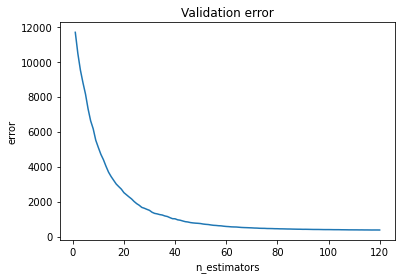

In [142]:
plt.plot(np.arange(1,121,1), errors)
plt.ylabel("error")
plt.xlabel("n_estimators")
plt.title("Validation error")

In [166]:
# early stopping using warm_start
# stop training when validation error does not improve for five iterations

# DOESNT WORK YET
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1,10000):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    print(val_error)
    if val_error < min_val_error:
        min_val_error = val_error
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping


11011.067662351348
9952.631745055669
8875.856573999677
8060.911010353565
7233.424889150544
6615.315856244883
5978.711211246689
5448.019209214344
4911.018469814301
4577.832929080031
4188.241908862358
3756.938040194436
3493.184602960829
3153.26503303125
2969.4416065049736
2726.878114845259
2505.4476617372957
2385.999330690328
2220.5745215985116
2057.9059254710264
1901.2361389030834
1755.1296551931982
1652.788261657914
1562.930386815668
1485.400523800996
1411.7089106330893
1323.6421935430817
1250.8472828493818
1213.5188829409788
1136.057061165415
1083.9694750245574
1038.4920434052492
990.4613064917874
947.5181350957922
892.963148954426
863.8800208558195
828.0741585110038
787.702717984299
756.5482884473618
730.3409925925536
715.1986170153151
688.1988682582304
657.9597395302839
636.6877853262749
619.5935764293565
606.7242774576791
594.221072698327
570.6234125516006
559.5228672245318
548.3405791925477
533.1549898237129
522.3873424562448
513.5292190993871
501.73658606838586
488.8252024492745


In [165]:
val_error

303.1504745777736

In [148]:
# Build model with optimal n_estimators

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=115)
gbrt_best.fit(X_train, y_train)
gbrt_best.score(X_test, y_test)

0.9752710477013901